In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.feature_selection import RFECV, SequentialFeatureSelector
from tqdm import tqdm
import sys
sys.path.append('../')

from TS_model.feature_engeneering import FeatureEngineer
from TS_model.feature_selection import WrapperMethod, StabilityAnalysis, DefaultMethod, FilterMethod

%load_ext autoreload
%autoreload 2

# Выгрузка изначальных данных & Feature engeneering

In [2]:
data = pd.read_excel('../Project 2_2023.xlsx', parse_dates=True, index_col=0)
data.columns = data.columns.str.lower()
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,income,outcome,balance
0,2017-01-09,1.343028,1.487865,-0.144836
1,2017-01-10,1.068610,1.194182,-0.125572
2,2017-01-11,0.944429,0.936663,0.007767
3,2017-01-12,1.672202,0.875379,0.796823
4,2017-01-13,0.955924,0.975645,-0.019721


In [3]:
feature_extactor = FeatureEngineer(data)

In [4]:
feature_extactor.add_lag_features(lags=[1, 2, 3, 7, 30, 60])
feature_extactor.add_rolling_features(windows=[3, 7, 30])
feature_extactor.add_seasonal_features()
# feature_extactor.add_special_dates() ТУТ НАДО ПЕРЕДАТЬ ДАТЫ НАЛОГОВОГО КАЛЕНДАРЯ В ФОРМАТЕ КОТОРЫЙ ЗАШИТ В МЕТОДЕ ИЛИ ПОМЕНЯТЬ МЕТОД
# add_macro_features() ДАТАФРЕЙМ МАКРО ФИЧЕЙ
data_more, _ = feature_extactor.get_feature_df()

In [5]:
data_all = data.copy().merge(data_more.copy().dropna(), on=['date'], how='inner').sort_values(by='date').drop(['date'], axis=1)
features = data_all.copy().drop(['balance', 'income', 'outcome'], axis=1)
target = data_all.copy()['balance']

In [6]:
tscv = TimeSeriesSplit(n_splits=5)

# Feature selection 

## Встроенные методы

Index(['balance_lag1', 'income_lag2', 'income_lag3', 'outcome_lag3',
       'balance_lag7', 'outcome_lag7', 'outcome_lag30', 'outcome_lag60',
       'outcome_ma7', 'outcome_ma30', 'month', 'day_of_week_cos', 'dow_0',
       'dow_2'],
      dtype='object')


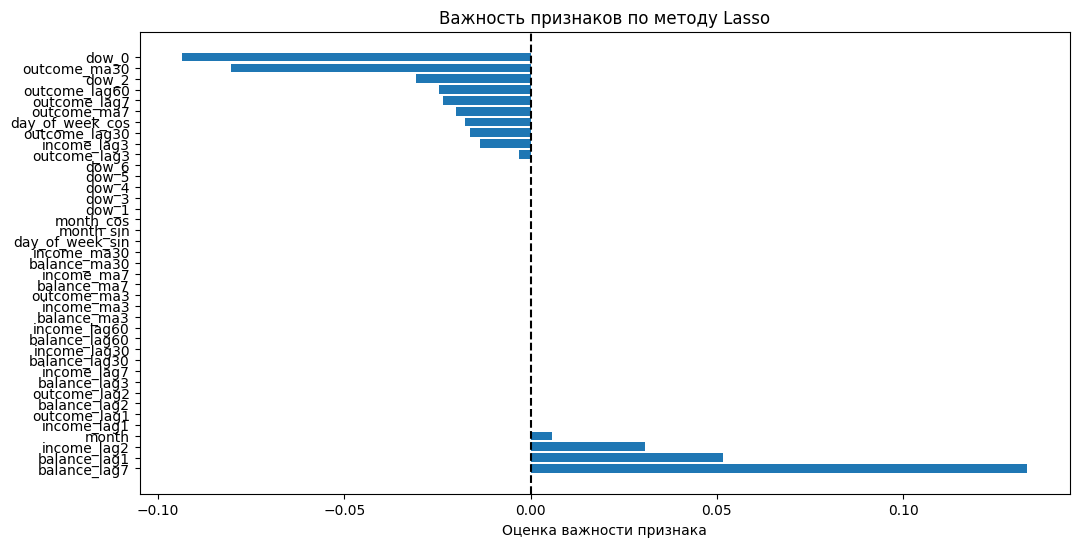

In [7]:
default = DefaultMethod()
default.fit(features, target)

lasso = LassoCV(cv=tscv, max_iter=10000, random_state=42)
print(default.implement(lasso))
default.vizualize()

Index(['balance_lag1', 'income_lag1', 'outcome_lag1', 'balance_lag2',
       'income_lag2', 'outcome_lag2', 'balance_lag3', 'income_lag3',
       'outcome_lag3', 'balance_lag7', 'income_lag7', 'outcome_lag7',
       'balance_lag30', 'income_lag30', 'outcome_lag30', 'balance_lag60',
       'income_lag60', 'outcome_lag60', 'balance_ma3', 'income_ma3',
       'outcome_ma3', 'balance_ma7', 'income_ma7', 'outcome_ma7',
       'balance_ma30', 'income_ma30', 'outcome_ma30', 'month',
       'day_of_week_cos', 'month_sin', 'month_cos', 'dow_0'],
      dtype='object')


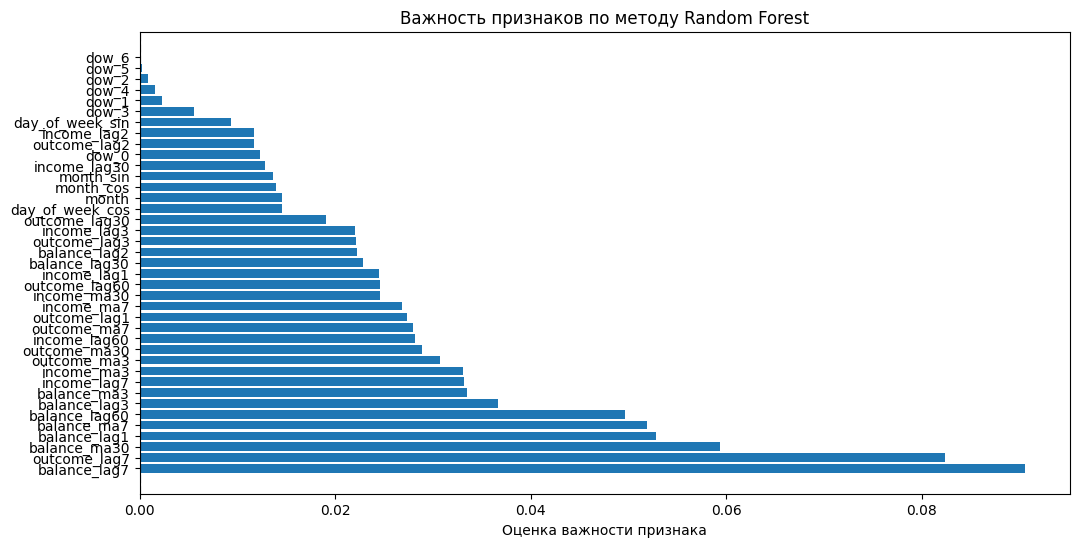

In [8]:
default = DefaultMethod()
default.fit(features, target)

random_forest = RandomForestRegressor(n_estimators=500, random_state=42)
print(default.implement(random_forest))
default.vizualize()

## Оберточные методы

Отобранные признаки на основе lasso: Index(['balance_lag1', 'income_lag2', 'balance_lag7', 'outcome_ma30', 'dow_0',
       'dow_2'],
      dtype='object')


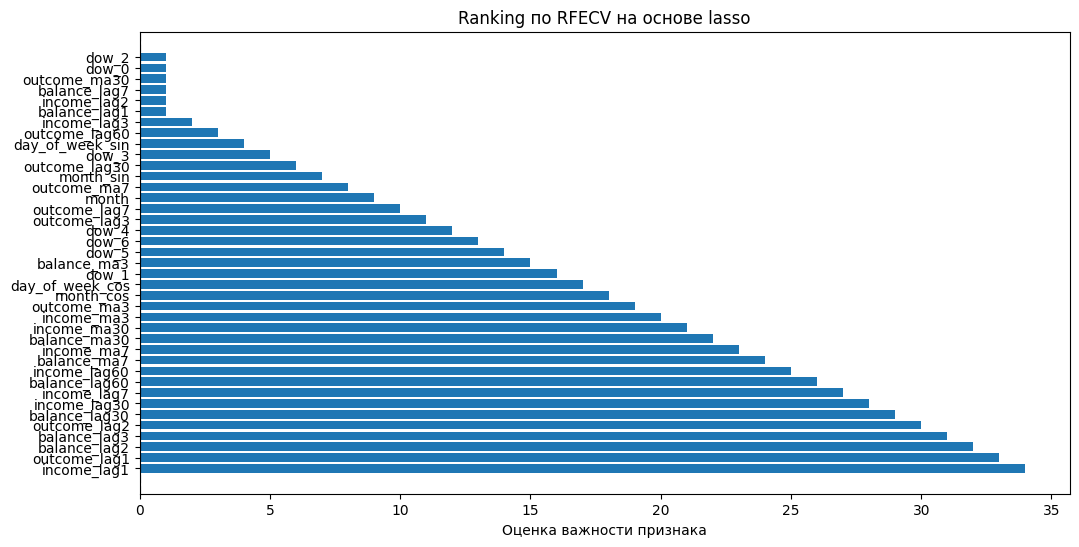

Отобранные признаки на основе elastic_net: Index(['balance_lag1', 'balance_lag7', 'balance_ma7', 'outcome_ma30', 'dow_0'], dtype='object')


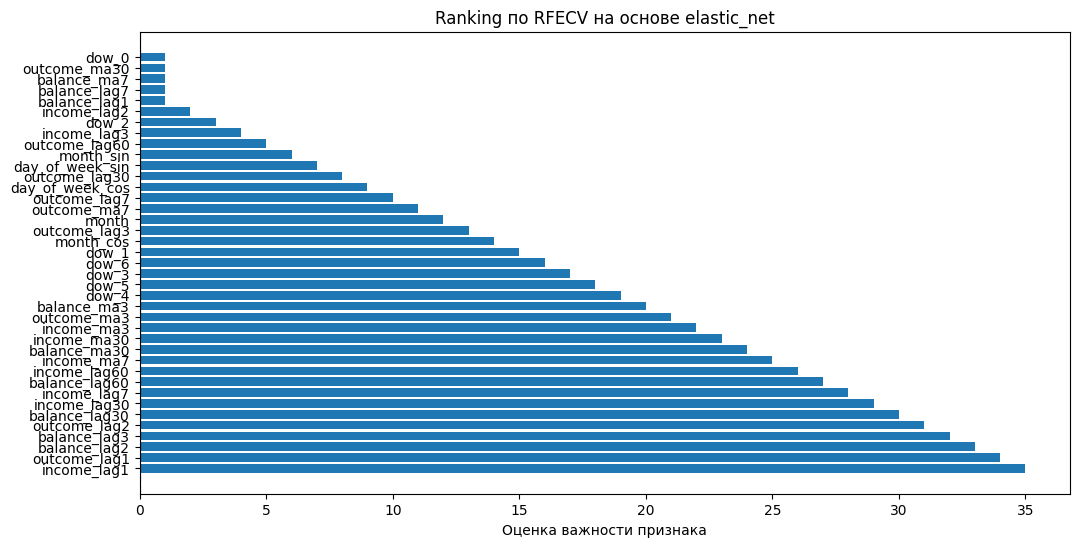

Отобранные признаки на основе random_forest: Index(['balance_lag1', 'income_lag1', 'outcome_lag1', 'balance_lag2',
       'income_lag2', 'outcome_lag2', 'balance_lag3', 'income_lag3',
       'outcome_lag3', 'balance_lag7', 'income_lag7', 'outcome_lag7',
       'balance_lag30', 'income_lag30', 'outcome_lag30', 'balance_lag60',
       'income_lag60', 'outcome_lag60', 'balance_ma3', 'income_ma3',
       'outcome_ma3', 'balance_ma7', 'income_ma7', 'outcome_ma7',
       'balance_ma30', 'income_ma30', 'outcome_ma30', 'month',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'dow_0'],
      dtype='object')


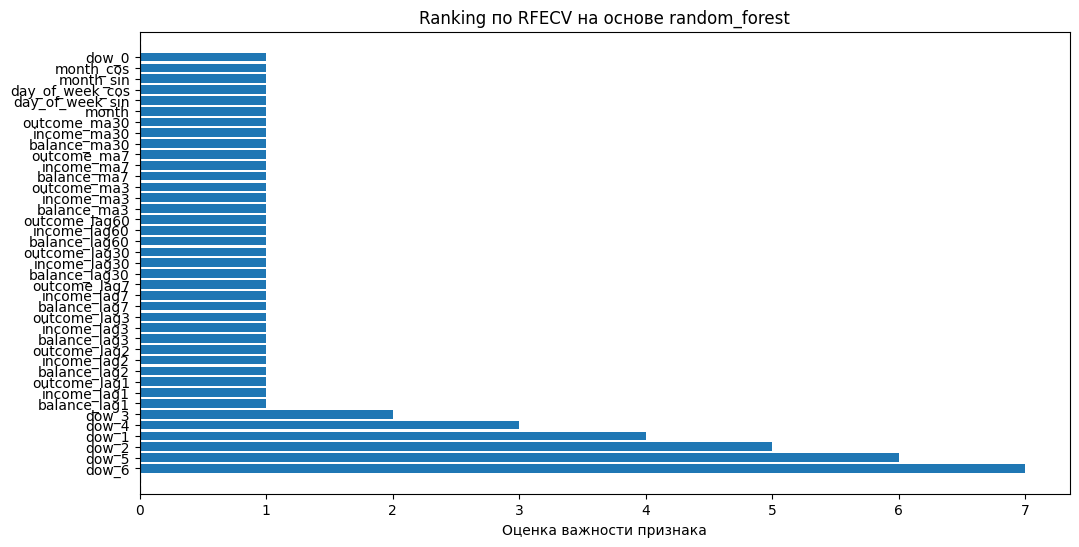

In [9]:
models_for_wrapper = {
    'lasso': LassoCV(cv=tscv, max_iter=10000, random_state=42), 
    'elastic_net': ElasticNetCV(cv=tscv, max_iter=10000, random_state=42), 
    'random_forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

wrapper = WrapperMethod()
wrapper.fit(features, target)

for name, model in models_for_wrapper.items():
    res = wrapper.implement(model, tscv)
    print(f'Отобранные признаки на основе {name}: {res}', end='\n')
    
    wrapper.vizualize(f'Ranking по RFECV на основе {name}')

## Фильтрационные методы

['balance_lag1', 'balance_lag2', 'income_lag2', 'outcome_lag2', 'balance_lag3', 'income_lag3', 'outcome_lag3', 'balance_lag30', 'income_lag30', 'outcome_lag30', 'balance_lag60', 'income_lag60', 'outcome_lag60', 'month', 'month_sin', 'month_cos', 'dow_5', 'dow_6']


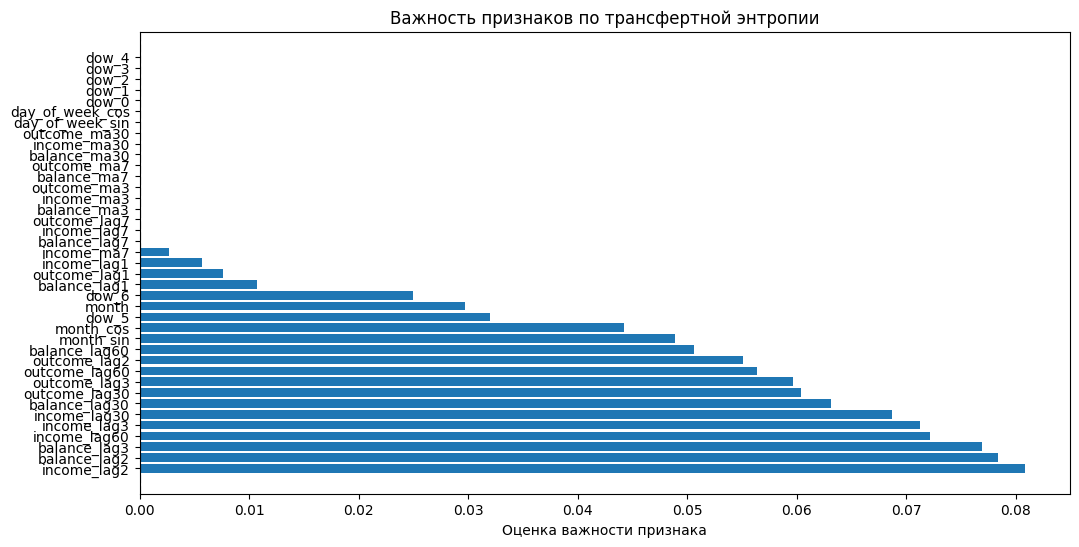

In [10]:
filter = FilterMethod()
filter.fit(features, target)

print(filter.implement(k=5))
filter.vizualize('Важность признаков по трансфертной энтропии')

# Оценка стабильности

In [17]:
method_params = {
    'default': {
        'Lasso': {'model': LassoCV(cv=tscv, max_iter=10000, random_state=42)}, 
        'RandomForest': {'model': RandomForestRegressor(n_estimators=500, random_state=42)}
    }, 
    'wrapper': {
        # 'Lasso': {'model': LassoCV(cv=tscv, max_iter=10000, random_state=42), 'tscv': tscv},
        # 'ElasticNet': {'model': ElasticNetCV(cv=tscv, max_iter=10000, random_state=42), 'tscv': tscv}, 
        'RandomForest': {'model': RandomForestRegressor(n_estimators=100, random_state=42), 'tscv': tscv}
    }, 
    'filter': {
        'TransferEntropy': {'k': 5}
    }
}

methods = []
method_configs = []
stabilities = []

stability_eval = StabilityAnalysis()
stability_eval.fit(features, target)

for method, params in tqdm(method_params.items()):
    for method_config, param in params.items():
        stability_eval.collect_binary(n_splits=5, method=method, **param)
        method_stability = stability_eval.implement()
        
        methods.append(method)
        method_configs.append(method_config)
        stabilities.append(method_stability)

100%|██████████| 3/3 [05:38<00:00, 112.77s/it]


In [18]:
pd.DataFrame(
    {
        'method': methods, 
        'method_config': method_configs, 
        'stability': stabilities
    }
)

,method,method_config,stability
0,default,Lasso,0.369759
1,default,RandomForest,0.695513
2,wrapper,RandomForest,0.382310
3,filter,TransferEntropy,0.616831
